# First Exploration of Synthesized beams
### JCH - March 2025

The idea is to explore the various synthesized beam modelings that are available in the Qubic code. We will investigate the implementation of the following models:
- Theoretical synthesized beam models (e.g. Gaussian approximations, Physical-Optics models, etc.)
- Implementation of measured synthesized beams models in the code (as done by Michael Wright)

We will also overview the various `CalFiles` associated with these synthesized beams models and update them to the most recent knowledge.

Here's the task that was decided and assigned to JCH during the APC D/A meeting on March 11th 2025:
```
code from Michael Wright about the use of calibration files. This code is mainly the following files : Qinstrument.py, Qbeams.py, Qcalibration.py, maybe others. There is different things to do, I will try to list what I found so far:
- Verify the code
- Avoid running the calibration file code when you haven't select the parameter to use them
- Long term task: test the calibration files that are currently in the qubicsoft, and start to discuss about making additional ones
```

In [1]:
# Mandatory imports
%config InlineBackend.figure_format='retina'
from IPython.display import display, HTML

%matplotlib widget
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits


from qubic.lib.Qdictionary import qubicDict
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene

plt.rcParams['figure.figsize'] = (8,4)

def print_keys(d, keys):
    for key in keys:
        print(' - {:25}: {}'.format(key, d[key]))
    print('\n')

# Analytical beam positions
We first use the `_peak_angles()` function from `QubicInstrument` to get the analytical positions and apmlitudes of the peaks in the synthesized beam and we compare them to the actual synthesized beam image obtained also analyticall from `get_synthbeam()` function (also from `QubicInstrument`). We should get exact results (or almost, the image is pixellised so some small effect are to be expected, but should reduce with higher `nside`).

In order to do so, we set:
```
d['synthbeam'] = None         # we put nothing
d['use_synthbeam_fits_file'] = False
```
to tell the code not to attempt to read a CalFile for the synthesized beam and make sure it uses the theoretical formulas.

It is important to check for the various cases here:
- TD and FI
- 150 and 220 GHz bands

None

values in dictionary:  qubic/qubic/dicts/global_source_oneDet.dict
 - beam_shape               : gaussian
 - synthbeam                : None
 - use_synthbeam_fits_file  : False



d[synthbeam] BEFORE QubicInstrument() : None
JC has modified this part !!!
There is no fits file given in this dictionary. Using analytical model of beam parameters
d[synthbeam] AFTER QubicInstrument() : None
    0:  0.0472    2.21       1
    1:  0.0512  -0.647   0.981
    2:   0.102   -2.83   0.671
    3:   0.104   -1.84   0.658
    4:   0.115    1.21   0.585
    5:   0.116   0.333   0.574
    6:   0.145    2.31   0.399
    7:   0.149  -0.738   0.376
    8:   0.171    2.92   0.266
    9:   0.174   -1.33   0.251
   10:   0.179    1.73   0.232
   11:   0.182  -0.171   0.219
   12:   0.195    -2.6   0.174
   13:   0.196   -2.09    0.17
   14:   0.209    1.01   0.132
   15:    0.21   0.539   0.129
   16:   0.239   -3.01  0.0679
   17:   0.241   -1.69  0.0639
   18:   0.244    2.33  0.0602
   19:    0.25  

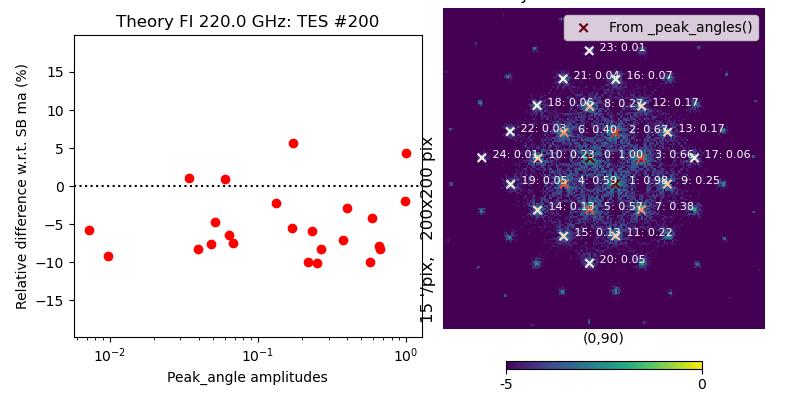

In [5]:
dictfilename = 'qubic/qubic/dicts/global_source_oneDet.dict'

# These are the relevant keys for this study in the dictionary
mykeys = ['beam_shape', 'synthbeam', 'use_synthbeam_fits_file']

d = qubicDict()
d.read_from_file(dictfilename)
d['config'] = 'FI'
d['filter_nu']= 220000000000.0
d['beam_shape'] = 'gaussian'  # can be 'gaussian', 'fitted_beam' or 'multi_freq'  
d['synthbeam'] = None         # we put nothing
d['nside'] = 512              # To have nice SB maps
d['use_synthbeam_fits_file'] = False
d['synthbeam_fraction'] = 1
d['synthbeam_kmax'] = 2


print(d['detector_nep'])

print('')
print('values in dictionary: ', dictfilename)
print_keys(d, mykeys)
print('')

print('d[synthbeam] BEFORE QubicInstrument() :', d['synthbeam'])
q_instrument = QubicInstrument(d)
print('d[synthbeam] AFTER QubicInstrument() :', d['synthbeam'])


q_scene = QubicScene(d)
thetas, phis, vals = q_instrument._peak_angles(q_scene, 
                                               d['filter_nu'], 
                                               q_instrument.detector.center, 
                                               q_instrument.synthbeam, 
                                               q_instrument.horn, 
                                               q_instrument.primary_beam)

idet = np.random.randint(248)
for i in range(np.shape(thetas)[1]):
    print('{0:5.0f}: {1:7.3g} {2:7.3g} {3:7.3g}'.format(i, thetas[idet,i], phis[idet, i], vals[idet, i]/np.max(vals[idet,:])))

######### Calculate full synthesized beam map
sb = q_instrument.get_synthbeam(q_scene, idet)
plt.figure()
plt.subplot(1,2,1)
pixnum = hp.ang2pix(d['nside'], thetas[idet,:], phis[idet,:])
newvals = (sb/np.max(sb))[pixnum]
plt.plot(vals[idet]/np.max(vals[idet,:]), 100*(vals[idet,:]/np.max(vals[idet,:])/newvals-1), 'ro')
ss = np.nanstd(vals[idet,:]/np.max(vals[idet,:])/newvals)
plt.ylim(-3*ss*100, 3*ss*100)
plt.axhline(y=0, ls=':', color='k')
plt.xscale('log')
plt.xlabel('Peak_angle amplitudes')
plt.ylabel('Relative difference w.r.t. SB ma (%)')
plt.title('Theory {} {} GHz: TES #{}'.format(d['config'], d['filter_nu']/1e9,idet))


hp.gnomview(np.log10(sb/np.max(sb)), rot=[0,90], reso=15, min=-5, max=0, sub=(1,2,2),
            title='Theory {} {} GHz: TES #{}'.format(d['config'], d['filter_nu']/1e9,idet))
hp.projscatter(thetas[idet,:], phis[idet,:], c=vals[idet,:]/np.max(vals[idet,:]), marker='x', cmap='Reds', label='From _peak_angles()')
for i in range(np.shape(thetas)[1]):
    hp.projtext(thetas[idet,i], phis[idet,i], 
                '{0:5.0f}: {1:4.2f}'.format(i, vals[idet,i]/np.max(vals[idet,:])), c='w', fontsize=8)
plt.legend(loc='upper right')
plt.tight_layout()



This is OK we do get what we expected. I also checked that removing the SynthBeam CalFiles does not create a crash when instanciateing a `QubicInstrument1

Next steps:
- study evolution with frequency
- build a CalFile corresponding to the theoretical information

## Let's now explore the evolution w.r.t. frequency:


values in dictionary:  qubic/qubic/dicts/global_source_oneDet.dict
 - beam_shape               : gaussian
 - synthbeam                : None
 - use_synthbeam_fits_file  : False



d[synthbeam] BEFORE QubicInstrument() : None
JC has modified this part !!!
There is no fits file given in this dictionary. Using analytical model of beam parameters
d[synthbeam] AFTER QubicInstrument() : None
[131.25  140.625 150.    159.375 168.75 ]
131.25
JC has modified this part !!!
There is no fits file given in this dictionary. Using analytical model of beam parameters
140.625
JC has modified this part !!!
There is no fits file given in this dictionary. Using analytical model of beam parameters
150.0
JC has modified this part !!!
There is no fits file given in this dictionary. Using analytical model of beam parameters
159.375
JC has modified this part !!!
There is no fits file given in this dictionary. Using analytical model of beam parameters
168.75
JC has modified this part !!!
There is no fits file 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


JC has modified this part !!!
There is no fits file given in this dictionary. Using analytical model of beam parameters


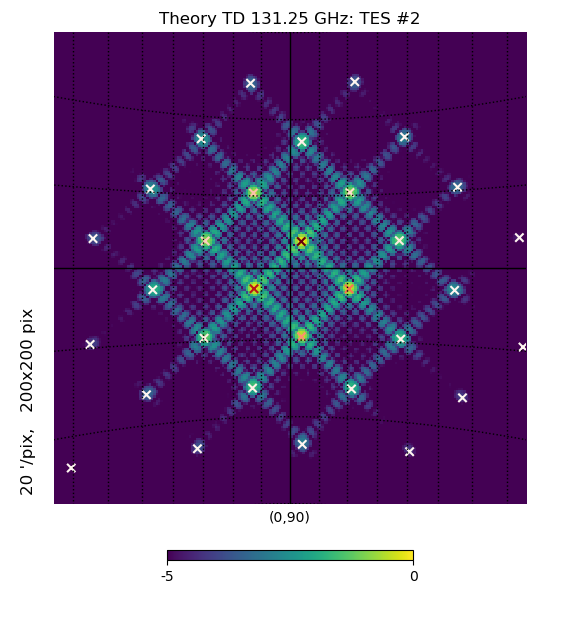

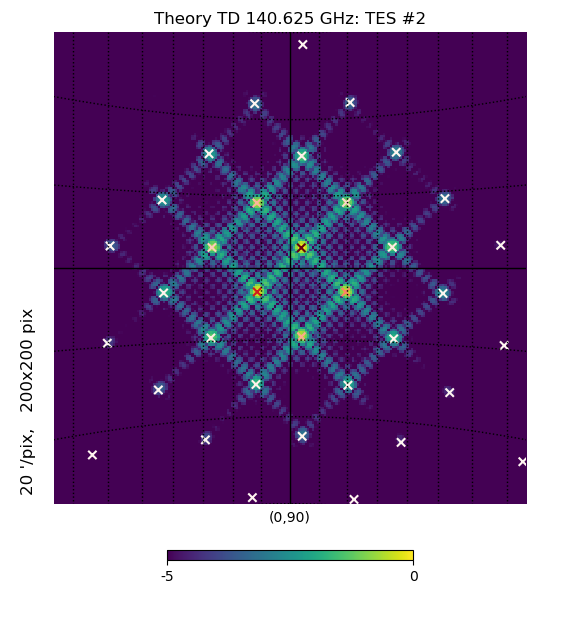

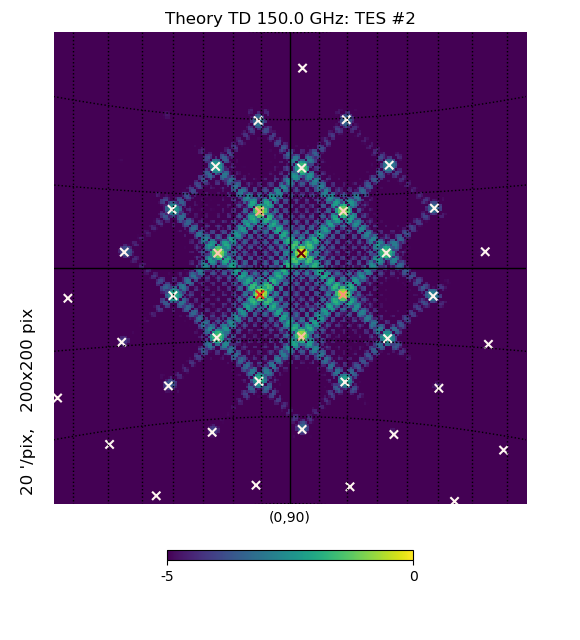

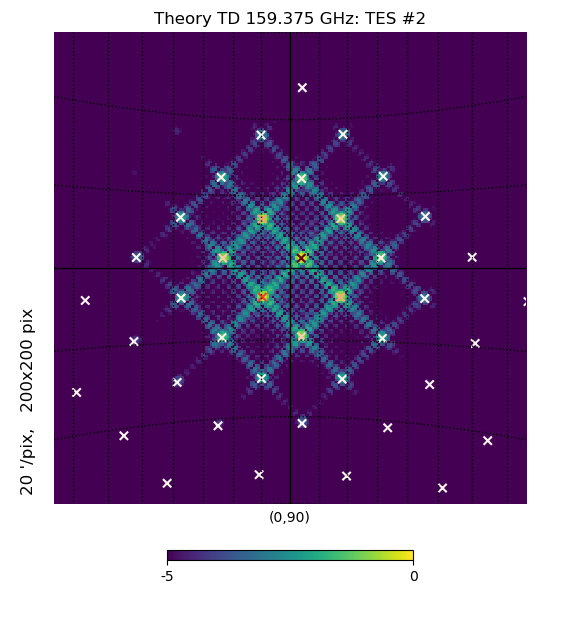

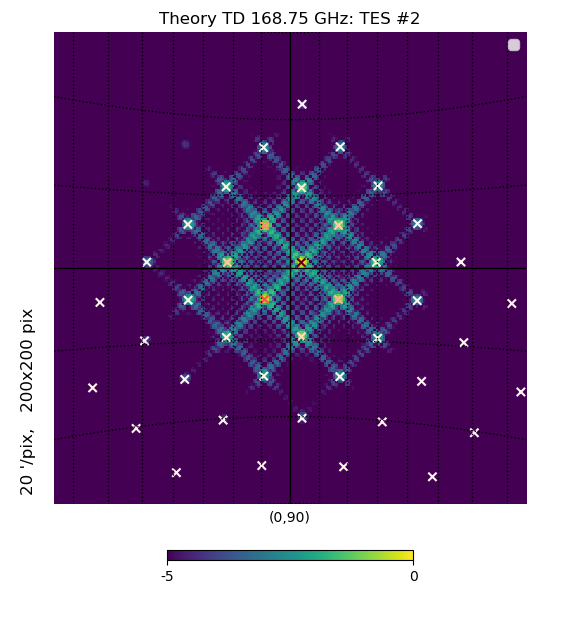

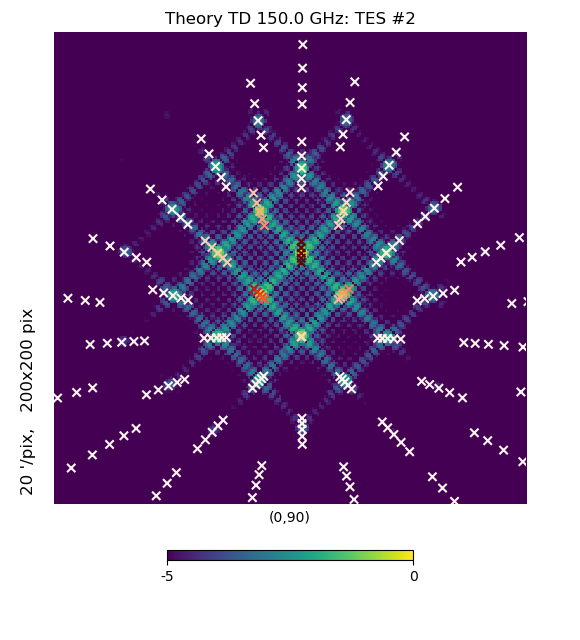

In [ ]:
d = qubicDict()
d.read_from_file(dictfilename)
d['config'] = 'TD'
d['filter_nu']= 150000000000.0
d['beam_shape'] = 'gaussian'  # can be 'gaussian', 'fitted_beam' or 'multi_freq'  
d['synthbeam'] = None         # we put nothing
d['nside'] = 512              # To have nice SB maps
d['use_synthbeam_fits_file'] = False
d['synthbeam_fraction'] = 1
d['synthbeam_kmax'] = 3

print('')
print('values in dictionary: ', dictfilename)
print_keys(d, mykeys)
print('')

print('d[synthbeam] BEFORE QubicInstrument() :', d['synthbeam'])
q_instrument = QubicInstrument(d)
print('d[synthbeam] AFTER QubicInstrument() :', d['synthbeam'])


central_freq = 150.
numin = central_freq * (1 - d['filter_relative_bandwidth']/2.)
numax = central_freq * (1 + d['filter_relative_bandwidth']/2.)
n_nus = 5
nus = np.linspace(numin, numax, n_nus)
print(nus)

idet = np.random.randint(248)

thetas = np.zeros((n_nus, 248, (2*d['synthbeam_kmax']+1)**2))
phis = np.zeros((n_nus, 248, (2*d['synthbeam_kmax']+1)**2))
vals = np.zeros((n_nus, 248, (2*d['synthbeam_kmax']+1)**2))
my_sbs = np.zeros((n_nus, 12*d['nside']**2))
for i in range(n_nus):
    print(nus[i])
    d['filter_nu'] = nus[i] * 1e9
    q_instrument_i = QubicInstrument(d)
    q_scene_i = QubicScene(d)
    thetas[i,:,:], phis[i,:,:], vals[i,:,:] = q_instrument_i._peak_angles(q_scene_i, 
                                                d['filter_nu'], 
                                                q_instrument_i.detector.center, 
                                                q_instrument_i.synthbeam, 
                                                q_instrument_i.horn, 
                                                q_instrument_i.primary_beam)
    my_sbs[i,:] = q_instrument_i.get_synthbeam(q_scene_i, idet)


for i in range(n_nus):
    hp.gnomview(np.log10(my_sbs[i,:]/np.max(my_sbs[i,:])), rot=[0,90], reso=20, min=-5, max=0,
             title='Theory {} {} GHz: TES #{}'.format(d['config'], nus[i],idet))
    hp.graticule()
    hp.projscatter(thetas[i, idet,:], phis[i, idet,:], c=vals[i, idet,:]/np.max(vals[i, idet,:]), marker='x', cmap='Reds')
plt.legend(loc='upper right')
plt.tight_layout()


####################################################
d['filter_nu'] = central_freq * 1e9
q_instrument = QubicInstrument(d)
q_scene = QubicScene(d)
sb = q_instrument.get_synthbeam(q_scene, idet)
hp.gnomview(np.log10(sb/np.max(sb)), rot=[0,90], reso=20, min=-5, max=0,
             title='Theory {} {} GHz: TES #{}'.format(d['config'], d['filter_nu']/1e9,idet))
for i in range(n_nus):
    hp.projscatter(thetas[i, idet,:], phis[i, idet,:], c=vals[i, idet,:]/np.max(vals[i, idet,:]), marker='x', cmap='Reds')


# Calibration Files

In [10]:
### Reading the files directly
def read_myfile(filename):
    hdu = fits.open(filename)
    header = hdu[0].header
    theta = hdu[0].data
    phi = hdu[1].data
    val = hdu[2].data
    freqs = hdu[3].data
    return theta, phi, val, freqs, header


cal_directory = os.path.dirname(q_instrument.calibration.detarray)
allfiles = glob.glob(cal_directory+'/*Synthbeam*.fits')
for f in allfiles:
    print()
    print(os.path.basename(f))
    theta, phi, val, freqs, header = read_myfile(f)
    #print(header)
    print('    Nfreq = {}'.format(len(freqs)))
    print('   ', freqs)
    print('   Thetas: ',np.shape(theta))
    print('     Phis:',np.shape(phi))
    print('     Vals:',np.shape(val))



CalQubic_Synthbeam_Calibrated_Multifreq_FI.fits
    Nfreq = 15
    [132 134 136 139 141 143 146 148 151 153 156 159 161 164 167]
   Thetas:  (15, 10, 9)
     Phis: (15, 10, 9)
     Vals: (15, 10, 9)

CalQubic_Synthbeam_Maynooth_220_FI.fits
    Nfreq = 1
    [2.2e+11]
   Thetas:  (992, 9)
     Phis: (992, 9)
     Vals: (992, 9)

CalQubic_Synthbeam_Calibrated_JCH_FI.fits
    Nfreq = 10
    [7 7 6 4 7 6 3 8 5 4]
   Thetas:  (10, 9)
     Phis: (10, 9)
     Vals: (10, 9)

CalQubic_Synthbeam_Analytical_220_FI.fits
    Nfreq = 1
    [220]
   Thetas:  (992, 9)
     Phis: (992, 9)
     Vals: (992, 9)

CalQubic_Synthbeam_Analytical_Multifreq_MJW_FI.fits
    Nfreq = 11
    [133 136 137 141 146 148 151 156 161 166 220]
   Thetas:  (11, 992, 9)
     Phis: (11, 992, 9)
     Vals: (11, 992, 9)


OK, so we see that nost files are absurd. They need to be redone. The last one (CalQubic_Synthbeam_Analytical_Multifreq_MJW_FI.fits) seems to have the right structure although the frequencies are absurd:
```
CalQubic_Synthbeam_Analytical_Multifreq_MJW_FI.fits
    Nfreq = 11
    [133 136 137 141 146 148 151 156 161 166 220]
   Thetas:  (11, 992, 9)
     Phis: (11, 992, 9)
     Vals: (11, 992, 9)
```
So we will take this as an example format and fill it in another notebook.